# Revenue data understanding and preparation

In [57]:
#import all the dependencies
import numpy as np
import pandas as pd  #for working with the data frame
import matplotlib.pyplot as plt # for visualisation
from sklearn.ensemble import RandomForestRegressor #for using the machine learning models
from sklearn.model_selection import train_test_split# Using Skicit-learn to split data into training and testing sets
import warnings
warnings.filterwarnings("ignore")

In [58]:
# import the csv data
df_revenue = pd.read_csv('fake_clinic_data_extract_test.csv')


In [59]:
# let us find any missing values in the columns
print("Below is the sum of null value count in each column\n")
print(df_revenue.isna().sum())
print("\nTotal number of rows in the data are:",len(df_revenue))
print("\nThere are 375 records missing in revenue column out of",len(df_revenue))

Below is the sum of null value count in each column

appointment_date               0
clinic_name                    0
patient_id                     0
practitioner_id                0
appointment_duration_min       0
revenues_from_appointment    375
dtype: int64

Total number of rows in the data are: 4071

There are 375 records missing in revenue column out of 4071


### There are 375 (9.2%)records with null value in revenue column
### Instead of replacing this with the mean value, I think a better approach would be to replace the values by predictive modelling as there is strong dependency between the practitioner and appointment duration to revenue.
### Lets build the predictive model using Random forest Regression
### Data Preparation

In [60]:

# Copy only the required features
features = df_revenue[['clinic_name','practitioner_id','appointment_duration_min','revenues_from_appointment']].copy()

#convert the practitoner_id to string type
features = features.astype({"practitioner_id":str})

#one hot encoding
features = pd.get_dummies(features)

#get rows with na value
revenue_ind = features['revenues_from_appointment'].isna()
revenue_na = features[revenue_ind]

#drop the NA rows we will predict those values
features =features.dropna()

# Labels are the values we want to predict
labels = np.array(features['revenues_from_appointment'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('revenues_from_appointment', axis = 1)
revenue_na= revenue_na.drop('revenues_from_appointment', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)


### Data Train and Test split

In [61]:

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

### Train the model

In [62]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

### Predict and check the performance

In [63]:

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Baseline errors, and display average baseline error
baseline_errors = abs(np.mean(test_labels) - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))
# Print out the mean absolute error (mae)
print('Mean Absolute Error of the predicted values:', round(np.mean(errors), 2), 'degrees.')


Average baseline error:  104.85
Mean Absolute Error of the predicted values: 85.94 degrees.


### Lets replace the null values in the revenue column using our trained model

In [64]:
#the absolute error is less compatred to the average baseline error so we can use this model to replace null values in revenue
#let us replace the null values in the revenue column 
predict_na = rf.predict(revenue_na)
df_revenue['revenues_from_appointment'][revenue_ind]=predict_na

#print the na values
print("Now there are no null values in Data\n")
print(df_revenue.isna().sum())



Now there are no null values in Data

appointment_date             0
clinic_name                  0
patient_id                   0
practitioner_id              0
appointment_duration_min     0
revenues_from_appointment    0
dtype: int64


# Let us analyse each column of the file
## Appointment Date

In [65]:
#drop any duplicate date
df_revenue =df_revenue.drop_duplicates()

#convert the appointment date to a date data type
df_revenue['appointment_date'] = pd.to_datetime(df_revenue['appointment_date']).dt.date

#making sure that the data is sorted according to appointment date
df_revenue = df_revenue.sort_values(by='appointment_date')

# adding 2 more attributes which is appointment date in Year and month format
df_revenue['YearMonth']= df_revenue['appointment_date'].apply(lambda x:x.strftime('%Y %b'))
df_revenue['Yearmonth']= df_revenue['appointment_date'].apply(lambda x:x.strftime('%Y %m'))

#let us sum the revenue in accordance with Month
df_revenue_month=df_revenue[['YearMonth','revenues_from_appointment','Yearmonth']].copy()
df_revenue_month_agg = df_revenue_month.groupby(['YearMonth','Yearmonth']).sum(['revenues_from_appointment']).sort_values(by=['Yearmonth'])

#convert the  index to a data frame
df_revenue_month=df_revenue_month_agg.index.to_frame(index=False)
df_revenue_month['Total_Revenue'] = df_revenue_month_agg['revenues_from_appointment'].values
del df_revenue_month['Yearmonth']
print("Below is the Total revenue per month\n",df_revenue_month)

Below is the Total revenue per month
   YearMonth  Total_Revenue
0  2021 Jun    3583.731151
1  2021 Jul   60949.408551
2  2021 Aug   94088.841768
3  2021 Sep   99537.539987
4  2021 Oct   99373.951346
5  2021 Nov  136181.923521
6  2021 Dec  146052.241315


### Histogram of Appointment date

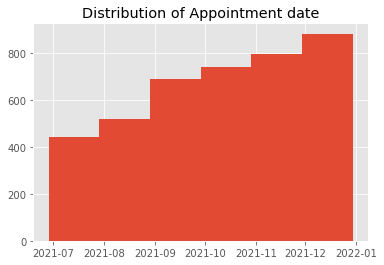

We can observe from above that the number of patient visit has increased over the duration



In [66]:
plt.style.use('ggplot')
plt.hist(df_revenue['appointment_date'],bins=6)
plt.title("Distribution of Appointment date")
plt.show()
print("We can observe from above that the number of patient visit has increased over the duration\n")

### Plot of revenue over the duration

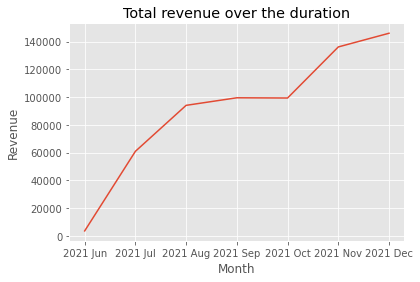

We can observe from above that the revenue shows an upward trend over the time 


In [67]:
plt.plot(df_revenue_month['YearMonth'],df_revenue_month['Total_Revenue'])
plt.title('Total revenue over the duration')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()
print("We can observe from above that the revenue shows an upward trend over the time ")

### Clinic Name

In [68]:
# create a dataframe with clinic name and revenue
df_revenue_clinic = df_revenue[['clinic_name','revenues_from_appointment']].copy()

#lets sum the revenue to clinic names
df_revenue_clinic_agg = df_revenue_clinic.groupby('clinic_name').sum(['revenues_from_appointment']).sort_values(by=['clinic_name'])

#print the result
print("Below is the total sum of revenue for both the clinic\n",df_revenue_clinic_agg)

Below is the total sum of revenue for both the clinic
              revenues_from_appointment
clinic_name                           
clinic_1                 327694.792237
clinic_2                 312072.845403


### Histogram of Clinic Name

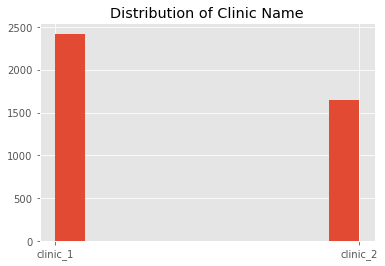

The number of appointments in clinic 1 are more than clinic 2



In [69]:
plt.style.use('ggplot')
plt.hist(df_revenue_clinic['clinic_name'].sort_values())
plt.title("Distribution of Clinic Name")
plt.show()
print("The number of appointments in clinic 1 are more than clinic 2\n")

### Bar chart of both clinic gross revenue

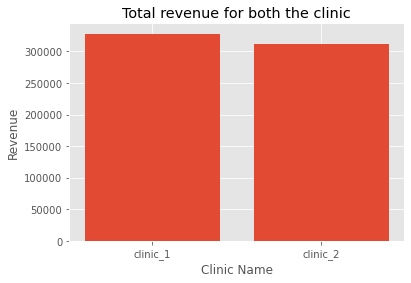

Both the clinic have almost similar gross revenue even though the clinic 1 had more number of appointments


In [70]:
plt.bar(df_revenue_clinic_agg.index,df_revenue_clinic_agg['revenues_from_appointment'])
plt.title('Total revenue for both the clinic')
plt.xlabel('Clinic Name')
plt.ylabel('Revenue')
plt.show()
print("Both the clinic have almost similar gross revenue even though the clinic 1 had more number of appointments")

### No of practitioner per clinic

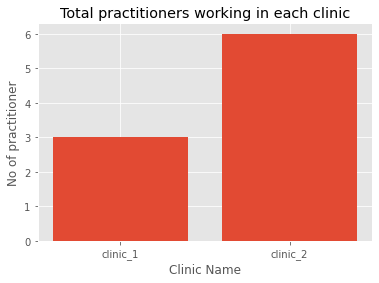

Clinic 2 has double the number of practioner compared to clinic 1 even though clinic 1 is more busy


In [71]:
# create a dataframe with clinic name and practitioner id
df_revenue_clinic_practitioner = df_revenue[['clinic_name','practitioner_id']].copy()

#total count of practitioner to clinic names
df_revenue_clinic_pract_count = df_revenue_clinic_practitioner.groupby('clinic_name').nunique()

#rename the column name
df_revenue_clinic_pract_count.rename(columns={'practitioner_id':'no_of_practitioner'},inplace=True)


#barplot
plt.bar(df_revenue_clinic_pract_count.index,df_revenue_clinic_pract_count['no_of_practitioner'])
plt.title('Total practitioners working in each clinic')
plt.xlabel('Clinic Name')
plt.ylabel('No of practitioner')
plt.show()
print("Clinic 2 has double the number of practioner compared to clinic 1 even though clinic 1 is more busy")

### Patient id

In [72]:
# create a dataframe with patient and clinic name
df_revenue_patient = df_revenue[['patient_id','clinic_name']].copy()

#lets sum how many patient visits which clinics 
df_revenue_patient_count = df_revenue_patient.groupby('clinic_name').nunique()

#rename the column name to number of patients
df_revenue_patient_count.rename(columns={'patient_id':'total_patient'},inplace=True)

#print the result
print("Below is the total sum of patients that visit both the clinics\n",df_revenue_patient_count)

Below is the total sum of patients that visit both the clinics
              total_patient
clinic_name               
clinic_1              1011
clinic_2               724


### Bar plot of total patient in both the clinic

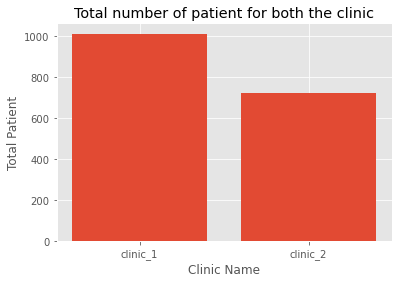

Clinic 1 has more number of patient


In [73]:
plt.bar(df_revenue_patient_count.index,df_revenue_patient_count['total_patient'])
plt.title('Total number of patient for both the clinic')
plt.xlabel('Clinic Name')
plt.ylabel('Total Patient')
plt.show()
print("Clinic 1 has more number of patient")

### Practitioner id

### Histogram of practitioner id

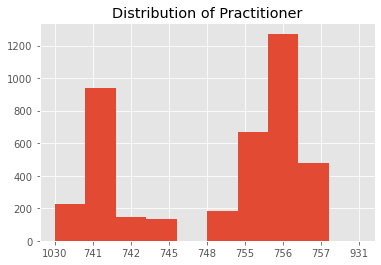

Practitioner 741 and 756 had more number of appointments


In [74]:
# create a dataframe with practitioner id and patient id
df_revenue_practitioner = df_revenue[['practitioner_id','patient_id']].copy()

# covert the pracitioner id to string
df_revenue_practitioner = df_revenue_practitioner.astype({"practitioner_id":str})

# Histogram of Practioner id
plt.style.use('ggplot')
plt.hist(df_revenue_practitioner['practitioner_id'].sort_values())
plt.title("Distribution of Practitioner")
plt.show()
print("Practitioner 741 and 756 had more number of appointments")

### Total patients associated with practitioners

Total patients associated with practitioners
                  no_of_patients
practitioner_id                
931                           1
757                         409
756                         637
755                         366
748                         113
745                         132
742                         147
741                         492
1030                        151


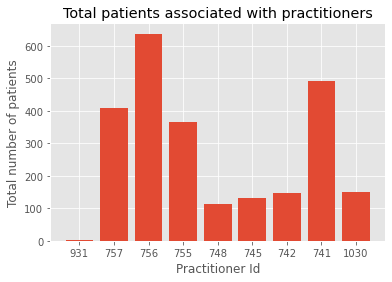

Patients are unevenly distributed among the practitioners


In [75]:
#lets find the total patient associated with practitioner 
df_revenue_pract_pat_count = df_revenue_practitioner.groupby('practitioner_id').nunique().sort_values('practitioner_id',ascending=False)

#rename the column name
df_revenue_pract_pat_count.rename(columns={'patient_id':'no_of_patients'},inplace=True)

#print the information
print("Total patients associated with practitioners\n",df_revenue_pract_pat_count)

#barplot
plt.bar(df_revenue_pract_pat_count.index,df_revenue_pract_pat_count['no_of_patients'])
plt.title('Total patients associated with practitioners')
plt.xlabel('Practitioner Id')
plt.ylabel('Total number of patients')
plt.show()
print("Patients are unevenly distributed among the practitioners")

### Total revenue each practioner generate

Total revenue associated with practitioners
                  total_revenue
practitioner_id               
931                 142.461833
757               52953.602234
756              180749.329787
755               93991.860215
748               24893.637729
745               17995.315958
742               18694.771498
741              214084.000239
1030              36262.658145


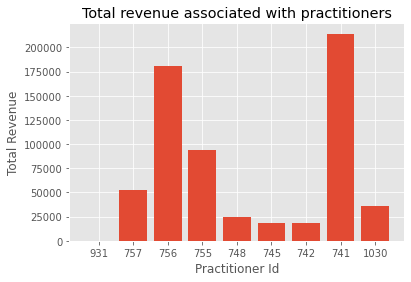

Practitioner 756 and 741 bring most of the revenue


In [76]:
# create a dataframe with practitioner id and revenues_from_appointment
df_revenue_practitioner = df_revenue[['practitioner_id','revenues_from_appointment']].copy()

# covert the pracitioner id to string
df_revenue_practitioner = df_revenue_practitioner.astype({"practitioner_id":str})

#lets find the total revenue associated with practitioner 
df_revenue_pract_revenue_sum = df_revenue_practitioner.groupby('practitioner_id').sum().sort_values('practitioner_id',ascending=False)

#rename the column name
df_revenue_pract_revenue_sum.rename(columns={'revenues_from_appointment':'total_revenue'},inplace=True)

#print the information
print("Total revenue associated with practitioners\n",df_revenue_pract_revenue_sum)

#barplot
plt.bar(df_revenue_pract_revenue_sum.index,df_revenue_pract_revenue_sum['total_revenue'])
plt.title('Total revenue associated with practitioners')
plt.xlabel('Practitioner Id')
plt.ylabel('Total Revenue')
plt.show()
print("Practitioner 756 and 741 bring most of the revenue")

### Appointment Duration

In [77]:
#stats of the data
print("Statistics of the appointment_duration_min\n ",df_revenue['appointment_duration_min'].describe())

#mode of appointment_duration_min
print("\nThe mode of the appointment duration:",df_revenue['appointment_duration_min'].mode().values,"\n")

#print the distribution
print("The distribution of Appointment duration \nApp Dur  Occurance\n",df_revenue['appointment_duration_min'].value_counts().sort_index())

#Observation
print("\nObservation: Most of the appointments were either of 15, 30 or 60 minutes ")



Statistics of the appointment_duration_min
  count    4061.000000
mean       42.295001
std        28.555367
min        15.000000
25%        30.000000
50%        30.000000
75%        60.000000
max       330.000000
Name: appointment_duration_min, dtype: float64

The mode of the appointment duration: [30] 

The distribution of Appointment duration 
App Dur  Occurance
 15      683
20        1
30     1658
40        1
45      332
55        6
60     1122
75       78
85        1
90       82
105      22
120      35
135       6
150       4
180       5
195       1
210       1
240       2
255       3
270       2
285       2
300      13
330       1
Name: appointment_duration_min, dtype: int64

Observation: Most of the appointments were either of 15, 30 or 60 minutes 


In [78]:
#stats of the revenue column
print("Statistics of the revenue attribute\n ",df_revenue['revenues_from_appointment'].describe())

#Observation
print("\n There is lot of variance in the revenue attribute")


Statistics of the revenue attribute
  count    4061.000000
mean      157.539433
std       235.069109
min        33.540000
25%        78.120000
50%       105.180000
75%       154.329300
max      5655.920000
Name: revenues_from_appointment, dtype: float64

 There is lot of variance in the revenue attribute


In [79]:
#create the dataframe to be exported to csv for forecasting 
df_revenue_forecast = df_revenue[['appointment_date','revenues_from_appointment']].copy()

# group data with date 
df_revenue_forecast = df_revenue_forecast.groupby('appointment_date').sum('revenues_from_appointment').sort_values('appointment_date')

#export to csv
df_revenue_forecast.to_csv("Revenue Forecast 2022.csv",index=True)

